In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV,RepeatedStratifiedKFold
#imported scalers but for decision trees they are realtively uneccessary.
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from hyperopt import STATUS_OK,Trials, fmin, hp, tpe


In [66]:
def remove_outliers(df: pd.DataFrame, n :float, columns):
    #this is the Tukey method which gets the values that exists outside of the outer fence of a histogram of a particular value
    #This is valuale if outliers effect the data alot (typically regression), in classification this might be different
    #Classifiaction in imbalanced datasets (like this one), might need outliers, so I am going to try with both

    total_outliers = []

    for col in columns:

        #generating the quantile ranges that will be used to determine outliers
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)

        iqr = q3 - q1
        outer_fence = iqr * 1.5

        outliers = df[(df[col] < q1 - outer_fence) | (df[col] > q3 + outer_fence)].index

        total_outliers.extend(outliers)

    #select the indexes (tuples) that have more than n attributes that are outliers (can scale)
    outliers = Counter(total_outliers)
    multiple_outliers = list(k for k , v in outliers.items() if v > n)


    return multiple_outliers



In [67]:
red_train = pd.read_csv("data/red_wine_train.csv",index_col=0)
red_test = pd.read_csv("data/red_wine_test.csv",index_col=0)

In [68]:
red_train.describe()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality,alcohol_higher,va_high
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.319077,0.526286,0.273901,0.087977,46.955825,0.996717,0.657842,10.443784,5.637217,0.164973,0.344019
std,1.760378,0.179513,0.196113,0.048290,33.370716,0.001930,0.169629,1.085611,0.808633,0.371301,0.475233
min,4.600000,0.120000,0.000000,0.012000,6.000000,0.990070,0.330000,8.400000,3.000000,0.000000,0.000000
25%,7.100000,0.390000,0.100000,0.070500,22.000000,0.995535,0.550000,9.500000,5.000000,0.000000,0.000000
50%,7.900000,0.520000,0.260000,0.079000,38.000000,0.996700,0.620000,10.200000,6.000000,0.000000,0.000000
75%,9.200000,0.635000,0.430000,0.091000,63.000000,0.997800,0.730000,11.100000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.000000,0.611000,289.000000,1.003690,2.000000,14.900000,8.000000,1.000000,1.000000


First Attempt: outlier removal, and dropping fixed acidity and chlordies, and the two binary variables (no binning)

In [69]:
red_train = red_train.drop(["chlorides", "fixed acidity","alcohol_higher", "va_high"], axis=1)
red_test= red_test.drop(["chlorides", "fixed acidity","alcohol_higher", "va_high"], axis=1)

<AxesSubplot: >

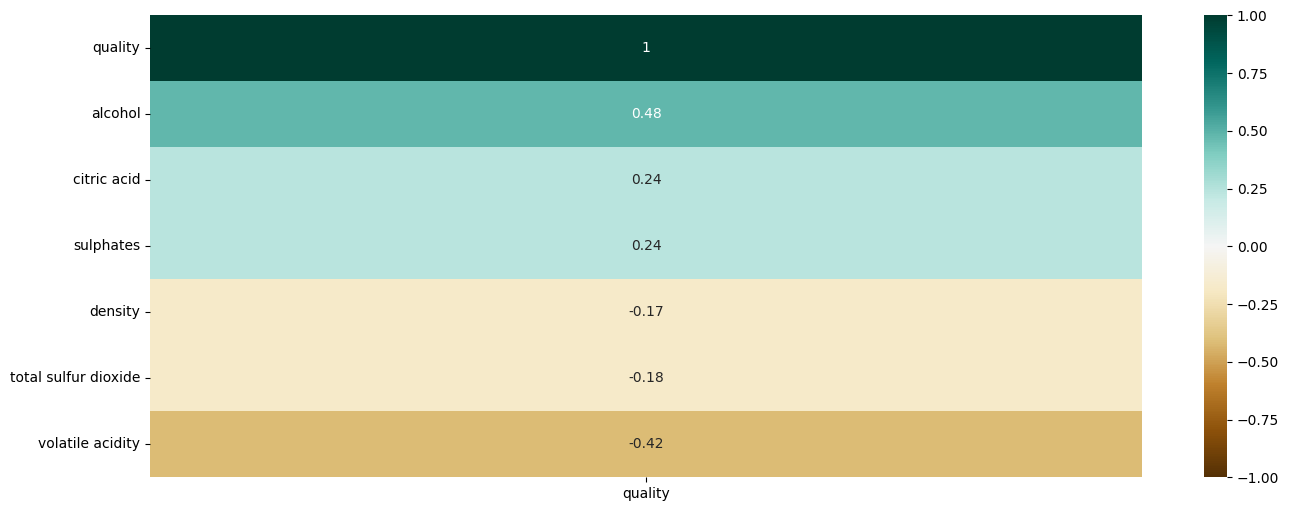

In [70]:
plt.figure(figsize=(16,6))
sns.heatmap(red_train.corr()[["quality"]].sort_values(by='quality',ascending=False), annot=True, vmin=-1,vmax=1,cmap='BrBG')

In [71]:
red_train

,volatile acidity,citric acid,total sulfur dioxide,density,sulphates,alcohol,quality
1338,0.500,0.00,26.0,0.99448,0.45,9.5,5
700,1.020,0.43,88.0,0.99840,0.57,10.1,6
873,0.210,0.37,10.0,0.99552,0.58,11.1,7
1586,0.310,0.41,60.0,0.99492,0.85,11.4,6
1373,0.750,0.27,89.0,0.99664,0.45,9.3,5
...,...,...,...,...,...,...,...
760,0.580,0.25,104.0,0.99779,0.57,9.7,5
493,0.690,0.31,81.0,1.00020,0.74,11.6,6
520,0.250,0.49,33.0,0.99820,0.90,10.0,6
1554,0.855,0.02,23.0,0.99627,0.60,11.0,6


In [72]:
#chose one as during Eda it seemed that individually there was not much
outliers = remove_outliers(red_train, 1 , red_train.columns[:-1])
red_train = red_train.drop(outliers, axis = 0).reset_index(drop=True)
red_train

,volatile acidity,citric acid,total sulfur dioxide,density,sulphates,alcohol,quality
0,0.500,0.00,26.0,0.99448,0.45,9.5,5
1,1.020,0.43,88.0,0.99840,0.57,10.1,6
2,0.210,0.37,10.0,0.99552,0.58,11.1,7
3,0.310,0.41,60.0,0.99492,0.85,11.4,6
4,0.750,0.27,89.0,0.99664,0.45,9.3,5
...,...,...,...,...,...,...,...
1254,0.580,0.25,104.0,0.99779,0.57,9.7,5
1255,0.690,0.31,81.0,1.00020,0.74,11.6,6
1256,0.250,0.49,33.0,0.99820,0.90,10.0,6
1257,0.855,0.02,23.0,0.99627,0.60,11.0,6


In [73]:
fig = make_subplots(rows=3,cols=3)

row = 0
col = 0

#loop to get a histogram of all features inside of the data set
for i in red_train.columns[:-1]:
    fig.append_trace(go.Histogram(
        x=red_train[i],
        name=i), row=row%2 +1,col=col%3 +1)
    
    col +=1
    row +=1

fig.show()

Most follow a gausian distribution, or are slightly skewed to the right (except citric acid). Gonna try and do a log function on them, but they appear to follow a normal distribution already if you apply the central limit theorm (except citric acid again)

In [74]:
X_train = red_train.drop("quality" , axis=1)
y_train = red_train["quality"]
X_test = red_test.drop("quality" , axis=1).copy()
y_test = red_test["quality"]

Hyper parameters:

    Booster: choose the type of booster to use (we will use tree in this case)
        -- 3 options 
        tree( gbtree,dart)
        linear(gblinear)

    Booster Parameters: only the tree booster ones, only listing the ones usuful to mulitlable imbalanced data (trees for the win)

        -- eta: the learning rat for Gradient boosting, and its range typically is 0.01 - 0.2
        -- gamma: how the node is split in a tree, the larger the more conservative a tree is, range(0 --> infinity)
        -- max_depth: maximum depth of a tree typical values are (3-10), should use cv
        -- min_child_weight: tune using cv but range is 0-->infinite
        -- subsample: fraction of observations to be samples for tree, lower values more conservative, typical values (0,1)
        -- tree method: constuction algorithm used in model (multiple choices)
        -- max_leaves: is maximum number of nodes to be added

        Others
        -- alpha : used for lasso regression, increasing makes the model more conservative
        -- lambda : used for ridge regression, increasing makes the model more conservative

    Learning Task: parameters used to define the optimization objective for learning 
        
        --objective: should use multi:softprob or multi: softmax
        --eval metric: should use auc, or merror

In [80]:
space = {"max-depth" : hp.quniform("max_dept",3,18,1),
         "gamma" : hp.uniform('gamma',1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=red_train["quality"]
)



1259

Hyperopt

    -- uses bayesian optimization to find the best parameter for machine learning algorithm, by using probablistic search of the hyperparamters supplied
       Compared to exahustive search it is much faster and its performance is only a bit lower

    How to implement:
        1. intitalise the domain space (same as a grid search)
        2. define the objective function  that we want to minimze (error rate) of the model that we are testing (XGBoost decision trees in this case)
        3. Optimize alogirhtm choice (the method used to construct the surrogate objective function)
        4. Results, the score or the value pairs that the algorithm uses to build the model

In [ ]:
#need to find out how to pass parameters: earning metric auc will be good for multilable, objective --> softprob,
#Generally will need to do some form of a gride search for the tree parameters (will need to set scale_pos_weight accordingly)
params = {'objective': "auc","scale_pos_weight"}
model = XGBClassifier()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=1)


XGB doesn't have the option for using the 